# Exercise: 2D Heat Transfer signature

Below is a function `ftcs` that uses second-order finite differences to solve a heat transfer problem.  

Add the `guvectorize` decorator (or function call!) with the appropriate signature and input/output layout so that the code block runs.  
The types of the arguments are:

1. `T` - 2d array of floats
2. `alpha` - float
3. `dt` - float
4. `dx` - float
5. `nt` - int
6. `Tn` - 2d array of floats

`T` and `Tn` have the same dimensions and are square.

In [2]:
import numpy
from numba import guvectorize, jit

In [3]:
def ftcs(T, alpha, dt, dx, Tn):
    I, J = T.shape
    for i in range(1, I - 1):
        for j in range(1, J - 1):
            Tn[i, j] = (T[i, j] + 
                      alpha * 
                      (dt / dx**2 * (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) + 
                       dt / dx**2 * (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1])))

    for i in range(I):
        Tn[i, 0] = T[i, 0]
        Tn[i, J - 1] = Tn[i, J - 2]

    for j in range(J):
        Tn[0, j] = T[0, j]
        Tn[I - 1, j] = Tn[I - 2, j]

In [4]:
def run_ftcs():
    L = 1.0e-2
    nx = 101
    nt = 1000
    dx = L / (nx - 1)
    x = numpy.linspace(0, L, nx)
    alpha = .0001
    sigma = 0.25
    dt = sigma * dx**2 / alpha

    Ti = numpy.ones((nx, nx), dtype=numpy.float64)
    Ti[0,:]= 100
    Ti[:,0] = 100

    for t in range(nt):
        Tn = ftcs(Ti, alpha, dt, dx)
        Ti = Tn.copy()
        
    return Tn, x

In [5]:
# %load snippets/guvectorize/ht_signature.py
@guvectorize(['float64[:,:], float64, float64, float64, float64[:,:]'], 
            '(m,m),(),(),()->(m,m)', nopython=True)
def ftcs(T, alpha, dt, dx, Tn):
    I, J = T.shape
    for i in range(1, I - 1):
        for j in range(1, J - 1):
            Tn[i, j] = (T[i, j] + 
                      alpha * 
                      (dt / dx**2 * (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) + 
                       dt / dx**2 * (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1])))

    for i in range(I):
        Tn[i, 0] = T[i, 0]
        Tn[i, J - 1] = Tn[i, J - 2]

    for j in range(J):
        Tn[0, j] = T[0, j]
        Tn[I - 1, j] = Tn[I - 2, j]

In [6]:
Tn, x = run_ftcs()

In [7]:
%timeit run_ftcs()

41.6 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
from matplotlib import pyplot, cm
%matplotlib inline

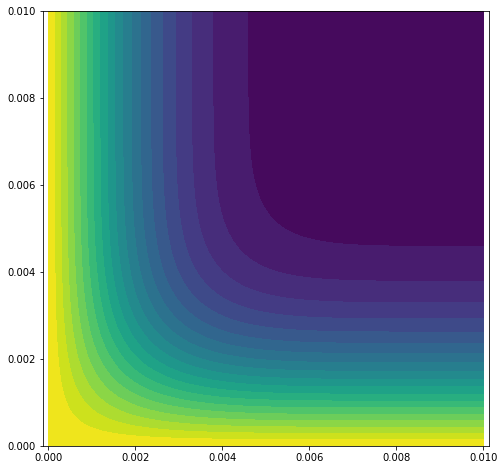

In [9]:
pyplot.figure(figsize=(8, 8))
mx, my = numpy.meshgrid(x, x, indexing='ij')
pyplot.contourf(mx, my, Tn, 20, cmap=cm.viridis)
pyplot.axis('equal');

# Exercise: 2D Heat Transfer Time loop

The example above loops in time outside of the `vectorize`d function.  That means it's looping in vanilla Python which is not the fastest thing in the world.  

What to do?  

Let's move the time loop inside the function.

You need to modify the parameter list to include the number of timesteps, `nt`, add the `guvectorize` decorator, and also adjust the signature according to the new paramters.  

Make sure to add the `copy()` statement within the time loop.

In [10]:
def ftcs_loop(T, alpha, dt, dx, Tn):
    I, J = T.shape
    for i in range(1, I - 1):
        for j in range(1, J - 1):
            Tn[i, j] = (T[i, j] + 
                      alpha * 
                      (dt / dx**2 * (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) + 
                       dt / dx**2 * (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1])))

    for i in range(I):
        Tn[i, 0] = T[i, 0]
        Tn[i, J - 1] = Tn[i, J - 2]

    for j in range(J):
        Tn[0, j] = T[0, j]
        Tn[I - 1, j] = Tn[I - 2, j]

In [15]:
def run_ftcs_vecloop():
    L = 1.0e-2
    nx = 101
    nt = 1000
    dx = L / (nx - 1)
    x = numpy.linspace(0, L, nx)
    alpha = .0001
    sigma = 0.25
    dt = sigma * dx**2 / alpha

    Ti = numpy.ones((nx, nx), dtype=numpy.float64)
    Ti[0,:]= 100
    Ti[:,0] = 100

    Tn = ftcs_loop(Ti, alpha, dt, dx, nt)
    
    return Tn, x

In [16]:
# %load snippets/guvectorize/ht_timeloop.py
@guvectorize(['float64[:,:], float64, float64, float64, int64, float64[:,:]'], 
            '(m,m),(),(),(),()->(m,m)', nopython=True)
def ftcs_loop(T, alpha, dt, dx, nt, Tn):
    I, J = T.shape
    for n in range(nt):
        for i in range(1, I - 1):
            for j in range(1, J - 1):
                Tn[i,j] = (T[i, j] + 
                          alpha * 
                          (dt/dx**2 * (T[i + 1, j] - 2*T[i, j] + T[i - 1, j]) + 
                           dt/dx**2 * (T[i, j + 1] - 2*T[i, j] + T[i, j - 1])))

        for i in range(I):
            Tn[i, 0] = T[i, 0]
            Tn[i, J - 1] = Tn[i, J - 2]

        for j in range(J):
            Tn[0, j] = T[0, j]
            Tn[I - 1, j] = Tn[I - 2, j]

        T = Tn.copy()

In [17]:
Tn, x = run_ftcs_vecloop()

In [18]:
%timeit run_ftcs_vecloop()

36.2 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


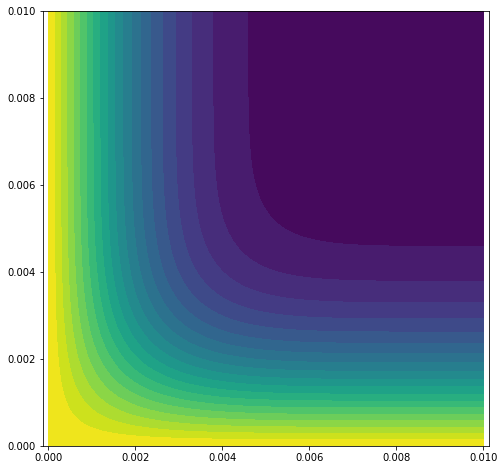

In [19]:
pyplot.figure(figsize=(8, 8))
pyplot.contourf(mx, my, Tn, 20, cmap=cm.viridis)
pyplot.axis('equal');